In [13]:
%matplotlib inline
import pandas as pd
import numpy as np

import tensorflow as tf
from keras import optimizers, Sequential
from keras.models import Model
from keras.utils import plot_model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import TensorBoard
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
df=[pd.read_pickle("/home/frank/Downloads/Dataset/data_y%d.pickle" %i) for i in range(3)]

In [165]:
df=pd.concat(df)

In [25]:
df[0].head(3)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24
0,0,0,3,10.152628,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,09
1,0,0,3,3.433987,0,0,0,0,0,1,...,1,1,0,1,9999,1,9999,9999,9999,09
2,1,1,3,11.075768,0,0,0,0,0,2,...,1,1,0,2,2,2,2,9999,2,09


In [167]:
df.shape

(223143, 26)

In [173]:
df=df.drop(['Y'],axis=1)

In [145]:
ratio=[df[df[col]==9999].shape[0]/len(df) for col in df.columns]

In [169]:
ratio

[0.0,
 0.008344424875528248,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.056708030276549116,
 0.009003195260438374,
 0.12003065298933868,
 0.0653034152987098,
 0.3079415442115594,
 0.45158037670910584,
 0.3105138857145418,
 0.2408455564369037,
 0.24084107500571383,
 0.24394670682029013,
 0.044666424669382414,
 0.274577289003016,
 0.056497403010625474,
 0.5122768807446346,
 0.7751173014613947,
 0.5163549831274116,
 0.0]

In [170]:
drop_col=['X'+str(idx) for idx, value in enumerate(ratio) if value>=0.2];drop_col

['X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X19', 'X21', 'X22', 'X23']

In [175]:
df.head(3)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X18,X20,X24
0,0,0,3,10.152628,0,0,0,0,0,0,0,0,0,0,09
1,0,0,3,3.433987,0,0,0,0,0,1,9999,0,1,1,09
2,1,1,3,11.075768,0,0,0,0,0,2,2,1,2,2,09


In [176]:
df.shape

(223143, 15)

In [177]:
#X0:customer
#X1:account
#X2:date(day difference)
#X24:month
df_word=df.iloc[:,3:14]
df_word.head(3)

,X3,X4,X5,X6,X7,X8,X9,X10,X11,X18,X20
0,10.152628,0,0,0,0,0,0,0,0,0,0
1,3.433987,0,0,0,0,0,1,9999,0,1,1
2,11.075768,0,0,0,0,0,2,2,1,2,2


In [178]:
def Amt_bin(amt,bin_num,rankAmt):
        for idx, th in enumerate(rankAmt):
            if amt<=th:
                return idx
        return bin_num

In [179]:
bin_num=20
rankAmt=[df_word['X3'].quantile(i/bin_num) for i in range(bin_num)]
df_word['X3']=df_word['X3'].apply(Amt_bin,args=(bin_num,rankAmt))
df_word.head(3)

,X3,X4,X5,X6,X7,X8,X9,X10,X11,X18,X20
0,8,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,9999,0,1,1
2,10,0,0,0,0,0,2,2,1,2,2


In [180]:
df_word=df_word.applymap(str)
df['word']=df_word.apply(lambda x: '_'.join(x),axis=1);df.head(3)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X18,X20,X24,word
0,0,0,3,10.152628,0,0,0,0,0,0,0,0,0,0,09,8_0_0_0_0_0_0_0_0_0_0
1,0,0,3,3.433987,0,0,0,0,0,1,9999,0,1,1,09,1_0_0_0_0_0_1_9999_0_1_1
2,1,1,3,11.075768,0,0,0,0,0,2,2,1,2,2,09,10_0_0_0_0_0_2_2_1_2_2


In [152]:
####LDA#####
df=df.sort_values(by=['X2'])

In [153]:
df.to_pickle("/home/frank/Downloads/Dataset/data_all.pickle")

In [154]:
df.head(3)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X18,X20,X24,word
0,0,0,3,10.152628,0,0,0,0,0,0,0,0,0,0,09,8_0_0_0_0_0_0_0_0_0_0
1316,94,82,3,7.239717,6,0,0,0,6,743,634,44,388,2,09,3_6_0_0_0_6_743_634_44_388_2
1315,74,62,3,10.898398,6,0,0,0,6,742,633,32,388,2,09,10_6_0_0_0_6_742_633_32_388_2


In [182]:
df['X24'].unique()

array(['09', '10', '11', '12', '01', '02', '03', '04', '05', '06'],
      dtype=object)

In [181]:
uniq_month=df['X24'].unique()
uniq_cust=df['X0'].unique()
vocab=df['word'].unique()
docs=[list(df[df['X0']==i]['word']) for i in range(len(uniq_cust))]
print('Total num of unique customer is: %d'%len(uniq_cust))
print('Total num of month is: %d'%len(uniq_month))
print(len(docs))

Total num of unique customer is: 740
Total num of month is: 10
740


In [183]:
each_doc_len=[len(docs[i]) for i in range(len(docs))] 
print(max(each_doc_len))
print(min(each_doc_len))
print(pd.Series(each_doc_len).describe())

143624
1
count       740.000000
mean        301.544595
std        5319.993036
min           1.000000
25%           4.000000
50%          17.000000
75%          32.000000
max      143624.000000
dtype: float64


In [184]:
###################
#### Gensim-LDA####
###################
import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from pprint import pprint
data=docs
data=[[str(word) for word in doc] for doc in data]
id2word=corpora.Dictionary(data)
corpus = [id2word.doc2bow(text) for text in data]

In [185]:
from time import time
def best_topic_num(dic,corpus,data,start,end,step):
    coherence_values = []
    model_list = []
    for num_topics in range(start,end, step):
        t0=time()
        model=gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dic,
                                           num_topics=num_topics , 
                                           random_state=0,
                                           update_every=1,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=data, dictionary=dic, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        #print('# %d is completed! This step costs %s sec'%(num_topics,str(time()-t0)))

    return model_list, coherence_values

In [186]:
#### best topic number #######
model_list, coherence_values = best_topic_num(dic=id2word, 
                                            corpus=corpus, 
                                            data=data, 
                                            start=3, 
                                            end=20, 
                                            step=1)

Num Topics = 3  has Coherence Value of 0.493936515103152
Num Topics = 4  has Coherence Value of 0.5040486995378433
Num Topics = 5  has Coherence Value of 0.5137090703184072
Num Topics = 6  has Coherence Value of 0.5237111167304239
Num Topics = 7  has Coherence Value of 0.4875892957851321
Num Topics = 8  has Coherence Value of 0.4456641356104918
Num Topics = 9  has Coherence Value of 0.4571009797088649
Num Topics = 10  has Coherence Value of 0.4853329483497224
Num Topics = 11  has Coherence Value of 0.48092971066268897
Num Topics = 12  has Coherence Value of 0.48375888660170857
Num Topics = 13  has Coherence Value of 0.4718996813665734
Num Topics = 14  has Coherence Value of 0.48023318061643244
Num Topics = 15  has Coherence Value of 0.47457083691541935
Num Topics = 16  has Coherence Value of 0.4699161780581005
Num Topics = 17  has Coherence Value of 0.4673734109361435
Num Topics = 18  has Coherence Value of 0.47584820440973835
Num Topics = 19  has Coherence Value of 0.44607379712352235

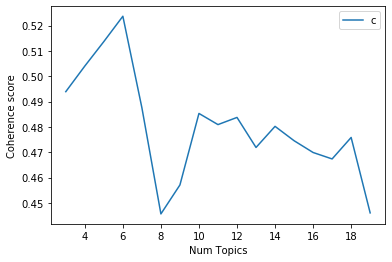

In [187]:
# Plotting tools
import matplotlib.pyplot as plt
%matplotlib inline
num_topic_range = range(3, 20, 1)
for x,y in zip(num_topic_range, coherence_values):
    print("Num Topics =", x, " has Coherence Value of", y)
plt.plot(num_topic_range, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [188]:
###############
##best-model###
###############
best_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=0,
                                           update_every=1,
                                           alpha='auto',
                                           per_word_topics=True)

In [189]:
predict_cluster=[[cust,best_model.get_document_topics(bow=corpus[cust])[0][0]] for cust in range(len(uniq_cust))]

In [190]:
predict_cluster_df=pd.DataFrame(predict_cluster,columns=['cust_id','cluster'])

In [191]:
df1=df.merge(predict_cluster_df,how='left',left_on='X0',right_on='cust_id')

In [196]:
df1.cluster.unique()

array([0, 1, 4, 2, 3, 5])

In [198]:
df1.head(3)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X18,X20,X24,word,cust_id,cluster
0,0,0,3,10.152628,0,0,0,0,0,0,0,0,0,0,09,8_0_0_0_0_0_0_0_0_0_0,0,0
1,0,0,3,3.433987,0,0,0,0,0,1,9999,0,1,1,09,1_0_0_0_0_0_1_9999_0_1_1,0,0
2,1,1,3,11.075768,0,0,0,0,0,2,2,1,2,2,09,10_0_0_0_0_0_2_2_1_2_2,1,1


In [199]:
##################
##Auto-encoder####
##################
df1['cluster'].value_counts()

0    152899
1     28122
2     22231
4      8150
3      7784
5      3957
Name: cluster, dtype: int64

In [203]:
df_sub=df1[df1['cluster']==0]

In [204]:
df_sub.head(3)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X18,X20,X24,word,cust_id,cluster
0,0,0,3,10.152628,0,0,0,0,0,0,0,0,0,0,09,8_0_0_0_0_0_0_0_0_0_0,0,0
1,0,0,3,3.433987,0,0,0,0,0,1,9999,0,1,1,09,1_0_0_0_0_0_1_9999_0_1_1,0,0
3,0,0,3,11.946955,0,0,0,0,0,3,3,0,3,3,09,11_0_0_0_0_0_3_3_0_3_3,0,0


In [205]:
df=df_sub.copy();df.head(3)

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X18,X20,X24,word,cust_id,cluster
0,0,0,3,10.152628,0,0,0,0,0,0,0,0,0,0,09,8_0_0_0_0_0_0_0_0_0_0,0,0
1,0,0,3,3.433987,0,0,0,0,0,1,9999,0,1,1,09,1_0_0_0_0_0_1_9999_0_1_1,0,0
3,0,0,3,11.946955,0,0,0,0,0,3,3,0,3,3,09,11_0_0_0_0_0_3_3_0_3_3,0,0


In [206]:
##########################
##Sample Generation#######
##########################
from tqdm import tqdm
from time import time
data=[]
uniq_month=df['X24'].unique()
uniq_cust=df['X0'].unique()
uniq_cust.sort()
time0=time()
for cust in tqdm(uniq_cust):
    for month in uniq_month:
        item=df[(df['X24']==month) &
                (df["X0"]== cust)].sort_values(by=['X2'])
        if item.shape[0]>=10:#why shape[0]>=10
            item=item.drop(['X0','X1','X2','X24','word','cust_id','cluster'],axis=1)
            data.append(item)
print(time()-time0)

100%|██████████| 371/371 [00:32<00:00, 11.76it/s]

32.01265478134155


In [210]:
print('Total num of sample is: %d' %len(data))
print('Total num of unique customer is: %d'%len(uniq_cust))
print('Total num of unique month is: %d'%len(uniq_month))

Total num of sample is: 135
Total num of unique customer is: 371
Total num of unique month is: 10


In [220]:
def rolling_window_x(x,lookback):
    rolling_x=[]
    for i in range(lookback, len(x)+1):
        rolling_x.append(x.iloc[(i-lookback):i,:])
    return rolling_x

In [221]:
#########################
###Generate 3D array####
#######################
###[np.array(mat_3D[i]) for i in range(len(mat_3D))]!!!!!
lookback=10
X=np.empty(shape=(1,10,data[0].shape[1]))
for sample in tqdm(range(len(data))):
    mat_3D=rolling_window_x(data[sample],lookback)
    mat_3D=np.array([np.array(mat_3D[i]) for i in range(len(mat_3D))])
    X=np.append(mat_3D,X,axis=0)
    #print('Sample %d has been completed!'%sample)
X.shape

100%|██████████| 135/135 [00:29<00:00, 37.07it/s]


(148673, 10, 11)

In [228]:
###split train and validate
X_train, X_valid,= train_test_split(X,test_size=0.2,random_state=123,shuffle=True)

In [229]:
####Training-LSTM-layer####
timesteps =  X.shape[1] # equal to the lookback
n_features =  X.shape[2] # 59

epochs = 10
batch = 64
lr = 0.001
hidden_unit_1=8
hidden_unit_2=4
##########
lstm_encoder = Sequential()
# Encoder
lstm_encoder.add(LSTM(hidden_unit_1, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_encoder.add(LSTM(hidden_unit_2, activation='relu', return_sequences=False))
lstm_encoder.add(RepeatVector(timesteps))
# Decoder
lstm_encoder.add(LSTM(hidden_unit_2, activation='relu', return_sequences=True))
lstm_encoder.add(LSTM(hidden_unit_1, activation='relu', return_sequences=True))
lstm_encoder.add(TimeDistributed(Dense(n_features)))

lstm_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 10, 8)             640       
_________________________________________________________________
lstm_20 (LSTM)               (None, 4)                 208       
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 10, 4)             0         
_________________________________________________________________
lstm_21 (LSTM)               (None, 10, 4)             144       
_________________________________________________________________
lstm_22 (LSTM)               (None, 10, 8)             416       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 10, 11)            99        
Total params: 1,507
Trainable params: 1,507
Non-trainable params: 0
_________________________________________________________________


In [230]:
###optim####
lstm_encoder.compile(loss='mse', optimizer=optimizers.Adam(lr))
###tb####
tb = TensorBoard(log_dir='/home/frank/Downloads/logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
###training###
lstm_encoder_history = lstm_encoder.fit(X_train, X_train, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid, X_valid),
                                                verbose=2).history

Train on 118938 samples, validate on 29735 samples
Epoch 1/10
 - 55s - loss: 7133374.6672 - val_loss: 7307459.7998
Epoch 2/10
 - 52s - loss: 6439337.1837 - val_loss: 6183663.7123
Epoch 3/10
 - 49s - loss: 6409422.3684 - val_loss: 10096806.4906
Epoch 4/10
 - 49s - loss: 5868474.9474 - val_loss: 5706309.3431
Epoch 5/10
 - 51s - loss: 5732445.5491 - val_loss: 5688693.4624
Epoch 6/10
 - 52s - loss: 5591846.4524 - val_loss: 5557409.0662
Epoch 7/10
 - 53s - loss: 5476557.4403 - val_loss: 5362137.0063
Epoch 8/10
 - 51s - loss: 5285838.3671 - val_loss: 5317009.8220
Epoch 9/10
 - 50s - loss: 5213827.7100 - val_loss: 5225354.6239
Epoch 10/10
 - 51s - loss: 5188463.1712 - val_loss: 5212218.7957


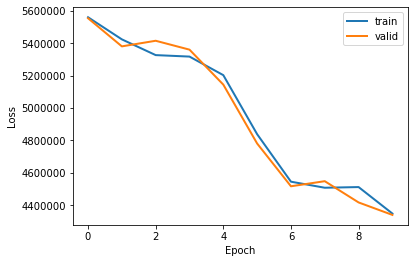

In [67]:
plt.plot(lstm_encoder_history['loss'], linewidth=2, label='train')
plt.plot(lstm_encoder_history['val_loss'], linewidth=2, label='valid')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Train on 121476 samples, validate on 30370 samples
Epoch 1/10
 - 52s - loss: 4041429.7448 - val_loss: 4034061.9104
Epoch 2/10
 - 55s - loss: 4020883.6228 - val_loss: 4041080.7832
Epoch 3/10
 - 52s - loss: 3991604.7278 - val_loss: 3997173.9799
Epoch 4/10
 - 49s - loss: 3974245.3337 - val_loss: 3993496.0069
Epoch 5/10
 - 49s - loss: 3999941.6274 - val_loss: 4012305.6852
Epoch 6/10
 - 50s - loss: 3971422.0097 - val_loss: 3992482.7734
Epoch 7/10
 - 49s - loss: 3952137.0820 - val_loss: 3971535.5643
Epoch 8/10
 - 50s - loss: 3939695.9752 - val_loss: 3959303.0400
Epoch 9/10
 - 50s - loss: 3930655.9123 - val_loss: 3948043.0143
Epoch 10/10
 - 51s - loss: 3983473.1448 - val_loss: 3962841.9572


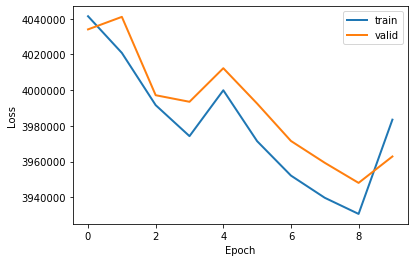

In [68]:
###optim####
lstm_encoder.compile(loss='mse', optimizer=optimizers.Adam(lr))
###tb####
tb = TensorBoard(log_dir='/home/frank/Downloads/logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
###training###
lstm_encoder_history = lstm_encoder.fit(X_train, X_train, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid, X_valid),
                                                verbose=2).history
###plot####
plt.plot(lstm_encoder_history['loss'], linewidth=2, label='train')
plt.plot(lstm_encoder_history['val_loss'], linewidth=2, label='valid')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [123]:
def back_to_2D(X):
    X_2D = np.empty((X.shape[0], X.shape[2]))  # sample x features array.
    for i in range(X.shape[0]):
        X_2D[i] = X[i, (X.shape[1]-1), :]
    return(X_2D)

x_valid_predict = lstm_autoencoder.predict(X_valid)
mse_valid = np.mean(np.power(back_to_2D(X_valid) - back_to_2D(x_valid_predict), 2), axis=1)
print(mse_valid.mean())
mse_valid

7108733.893407841


array([  139965.19044367,  4429080.1400424 ,   345387.8971236 , ...,
         158984.33617872, 59460675.55157475, 23681763.21939907])

In [95]:
len(mse_valid)

30370

In [83]:
####other ckuster reconstruction error###
df=df1[df1['cluster']==0]

In [84]:
##########################
##Sample Generation#######
##########################
from tqdm import tqdm
from time import time
data=[]
uniq_month=df['X24'].unique()
uniq_cust=df['X0'].unique()
uniq_cust.sort()
time0=time()
for cust in tqdm(uniq_cust):
    for month in uniq_month:
        item=df[(df['X24']==month) &
                (df["X0"]== cust)].sort_values(by=['X2'])
        if item.shape[0]>=10:
            item=item.drop(['X0','X1','X2','X24','word','cust_id','cluster'],axis=1)
            data.append(item)
print(time()-time0)

100%|██████████| 347/347 [00:10<00:00, 34.33it/s]

10.110053539276123


In [88]:
#########################
###Generate 3D array####
#######################
###[np.array(mat_3D[i]) for i in range(len(mat_3D))]!!!!!
lookback=10
X=np.empty(shape=(1,10,data[0].shape[1]))
for sample in tqdm(range(len(data))):
    mat_3D=rolling_window_x(data[sample],lookback)
    mat_3D=np.array([np.array(mat_3D[i]) for i in range(len(mat_3D))])
    X=np.append(mat_3D,X,axis=0)
    #print('Sample %d has been completed!'%sample)
X.shape

100%|██████████| 125/125 [00:04<00:00, 31.07it/s]


(17614, 10, 11)

In [96]:
x_predict = lstm_autoencoder.predict(X)
mse_other = np.mean(np.power(back_to_2D(X) - back_to_2D(x_predict), 2), axis=1)
print(mse_other.mean())
mse_other

16366317.444204189


array([30857378.36786979, 30857377.08657316, 48138755.37387685, ...,
        8176449.23854619,  3352284.28156547, 18191941.36363636])

In [97]:
mse_other.mean()-mse_valid.mean()

9257583.550796349

In [100]:
mse_other.mean()/mse_valid.mean()

2.3022830351521817

In [124]:
len(mse_valid)/len(mse_other)

1.7241966617463382

In [125]:
mse_valid,tp=train_test_split(mse_valid,test_size=0.5,random_state=123)

In [126]:
error_df=pd.DataFrame({'Recons_error':mse_valid,'cluster':4})

In [127]:
error_df=pd.concat([error_df,pd.DataFrame({'Recons_error':mse_other,'cluster':0})],axis=0)

In [128]:
error_df.head(3)

,Recons_error,cluster
0,5.298729e+03,4
1,3.573040e+07,4
2,2.424554e+07,4


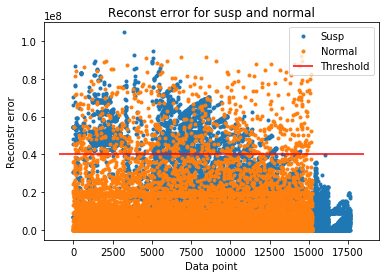

In [134]:
threshold_fixed = 0.4e8
groups = error_df.groupby('cluster')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Recons_error, marker='o', ms=3.0, linestyle='',
            label= "Susp" if name == 0 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconst error for susp and normal")
plt.ylabel("Reconstr error")
plt.xlabel("Data point")
plt.show();

In [132]:
####Train-Dense-layer###
####Training-LSTM-layer####
n_features =  X.shape[2] 
epochs = 10
batch = 64
lr = 0.001
hidden_unit_1=8
hidden_unit_2=4
##########
lstm_encoder = Sequential()
# Encoder
lstm_encoder.add(Dense(hidden_unit_1, activation='relu', input_shape=(n_features,)))
lstm_encoder.add(Dense(hidden_unit_2, activation='relu'))
# Decoder
lstm_encoder.add(Dense(hidden_unit_2, activation='relu'))
lstm_encoder.add(Dense(hidden_unit_1, activation='relu'))
lstm_encoder.add(Dense(n_features, activation='linear'))
lstm_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 8)                 96        
_________________________________________________________________
dense_17 (Dense)             (None, 4)                 36        
_________________________________________________________________
dense_18 (Dense)             (None, 4)                 20        
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 40        
_________________________________________________________________
dense_20 (Dense)             (None, 11)                99        
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [137]:
df2_sub=df1.copy()
df2_sub=df2_sub[df2_sub['cluster']==4]
df2_sub=df2_sub.drop(['X0','X1','X2','X24','word','cust_id','cluster'],axis=1)